# 멀티 에이전트 관리자

[이전 예제](./multi-agent-collaboration_ko.ipynb)에서는 초기 연구원 에이전트의 출력을 기반으로 메시지를 자동으로 라우팅했습니다.

[LLM을 사용하여](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) 여러 에이전트를 오케스트레이션할 수도 있습니다.

아래에서는 에이전트 그룹을 만들고, 태스크를 위임하는 데 도움을 줄 에이전트 관리자를 만들 것입니다.

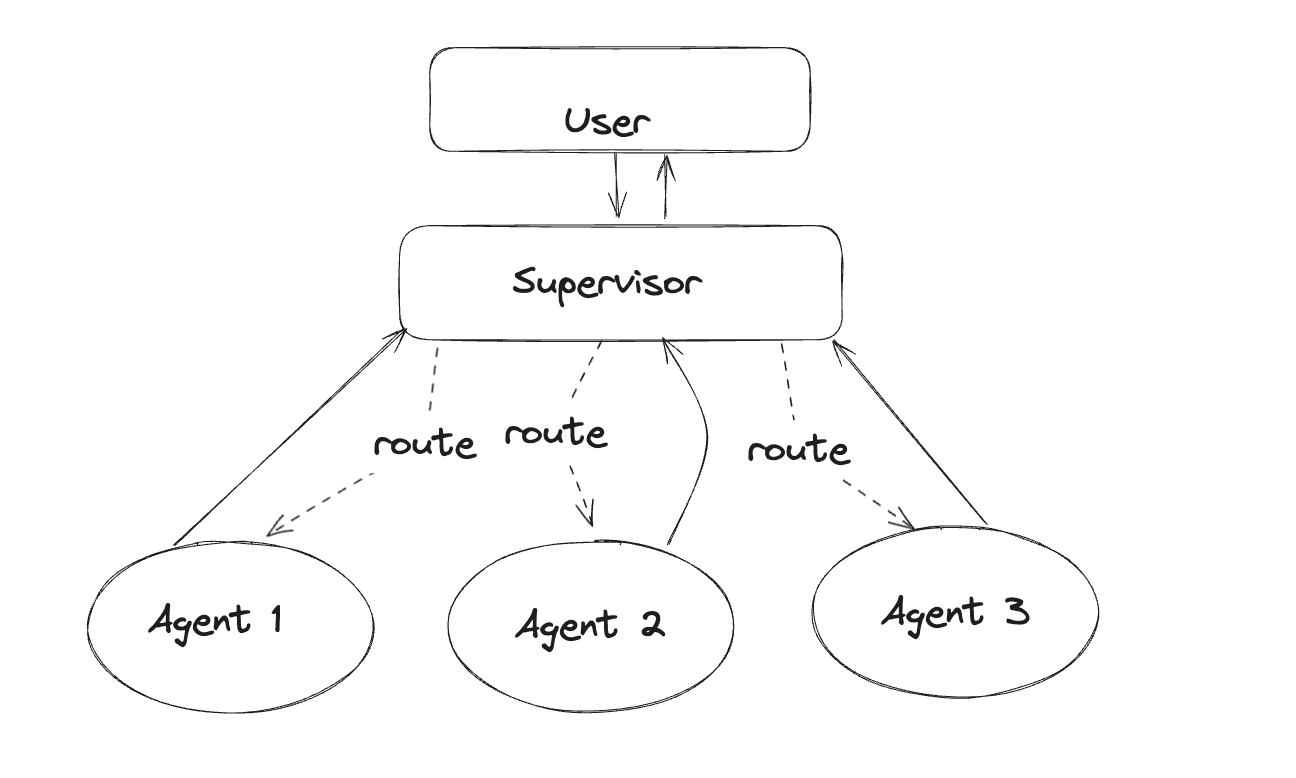

각 에이전트 노드의 코드를 단순화하기 위해 LangGraph에서 미리 빌드한 [create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent)를 사용합니다. 이 글의 예시는 LangGraph에서 특정 디자인 패턴을 구현하는 방법을 보여주기 위해 만들어졌습니다. 패턴이 필요에 맞는 경우, 최상의 성능을 위해 문서의 다른 곳에 설명된 다른 기본 패턴과 결합하는 것이 좋습니다.

## 설정

먼저 필요한 패키지를 설치하고 API 키를 설정합니다.

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental langchain_google_vertexai langchain-teddynote

In [19]:
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("generative-ai")

LangSmith 추적을 시작합니다.
[프로젝트명]
generative-ai


In [20]:
import langchain

langchain.debug = True

In [21]:
import getpass  # getpass를 import합니다.
import os  # os를 import합니다.
import dotenv

dotenv.load_dotenv()

# def _set_if_undefined(var: str):  # 환경 변수가 설정되지 않은 경우 설정하는 함수를 정의합니다.
#     if not os.environ.get(var):  # 환경 변수가 설정되어 있는지 확인합니다.
#         os.environ[var] = getpass.getpass(f"Please provide your {var}")  # 환경 변수가 설정되지 않은 경우 사용자로부터 입력을 받습니다.


# _set_if_undefined("ANTHROPIC_API_KEY")  # ANTHROPIC_API_KEY 환경 변수를 설정합니다.
# _set_if_undefined("TAVILY_API_KEY")  # TAVILY_API_KEY 환경 변수를 설정합니다.
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">LangGraph 개발을 위해 <a href="https://smith.langchain.com">LangSmith</a>를 설정하세요</p>
    <p style="padding-top: 5px;">
        LangSmith에 가입하여 문제를 신속하게 발견하고 LangGraph 프로젝트의 성능을 개선하세요. LangSmith를 사용하면 추적 데이터를 사용하여 LangGraph로 구축된 LLM 앱을 디버그, 테스트 및 모니터링할 수 있습니다. 시작하는 방법에 대한 자세한 내용은 <a href="https://docs.smith.langchain.com">여기</a>에서 확인하세요.
    </p>
</div>

## 도구 생성

이 예제에서는 검색 엔진으로 웹 연구를 수행하는 에이전트와 플롯을 생성하는 에이전트를 만들 것입니다. 아래에서 사용할 도구를 정의합니다.

In [23]:
# typing 모듈에서 Annotated를 가져옵니다.
from typing import Annotated

# langchain_community.tools.tavily_search 모듈에서 TavilySearchResults를 가져옵니다.
from langchain_community.tools.tavily_search import TavilySearchResults
# langchain_core.tools 모듈에서 tool을 가져옵니다.
from langchain_core.tools import tool
# langchain_experimental.utilities 모듈에서 PythonREPL을 가져옵니다.
from langchain_experimental.utilities import PythonREPL

# TavilySearchResults 도구를 초기화합니다. 최대 검색 결과 수는 5입니다.
tavily_tool = TavilySearchResults(max_results=5)

# PythonREPL 도구를 초기화합니다. 이 도구는 로컬에서 코드를 실행하므로 안전하지 않을 수 있습니다.
repl = PythonREPL()


# @tool 데코레이터를 사용하여 python_repl_tool 함수를 Langchain 도구로 등록합니다.
@tool
# python_repl_tool 함수를 정의합니다. 이 함수는 Python 코드를 실행하고 결과를 반환합니다.
def python_repl_tool(
    # code 인자에 대한 타입 힌트를 제공합니다. Annotated를 사용하여 코드에 대한 설명을 추가합니다.
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    # try-except 블록을 사용하여 코드 실행 중 발생할 수 있는 예외를 처리합니다.
    try:
        # repl.run() 메서드를 사용하여 Python 코드를 실행하고 결과를 result 변수에 저장합니다.
        result = repl.run(code)
    # BaseException이 발생하면 except 블록이 실행됩니다.
    except BaseException as e:
        # 오류 메시지를 반환합니다.
        return f"Failed to execute. Error: {repr(e)}"
    # 실행 결과를 문자열로 formatting합니다.
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    # 결과 문자열을 반환합니다.
    return result_str

### 에이전트 관리자 생성

LLM을 사용하여 구조화된 출력을 통해 다음 작업자 노드를 선택하거나 처리를 완료합니다.

<details>
    <summary>MessageState 정의</summary>
MessagesState는 LangGraph에서 대화 기록을 관리하기 위한 기본 상태 클래스입니다.([1](https://python.langchain.com/docs/modules/memory/))

주요 특징은 다음과 같습니다:

1. 메시지 저장 및 관리
2. 대화 기록 유지
3. 상태 전이 지원

```python
print(state["messages"])

# 출력:
[
    HumanMessage(content='안녕하세요'),
    AIMessage(content='안녕하세요! 무엇을 도와드릴까요?'),
    HumanMessage(content='오늘 날씨는 어떤가요?')
]
```

MessagesState는 다음과 같은 상황에서 특히 유용합니다:

1. 멀티턴 대화 시스템 구축
2. 대화 컨텍스트 유지
3. 상태 기반 대화 관리
4. 에이전트 간 메시지 전달
</details>

In [34]:
# typing 모듈에서 Literal을 가져옵니다. Literal은 특정 값 집합으로 제한된 타입을 정의하는 데 사용됩니다.
from typing import Literal
# typing_extensions 모듈에서 TypedDict를 가져옵니다. TypedDict는 딕셔너리의 키와 값의 타입을 명시적으로 정의하는 데 사용됩니다.
from typing_extensions import TypedDict

# from langchain_anthropic import ChatAnthropic
# langchain_google_vertexai 라이브러리에서 ChatVertexAI를 가져옵니다. Vertex AI의 Chat 모델을 사용하기 위함입니다.
from langchain_google_vertexai import ChatVertexAI
# langgraph.graph 모듈에서 MessagesState, END를 가져옵니다. MessagesState는 메시지 상태 관리에, END는 그래프의 종료 노드를 나타냅니다.
from langgraph.graph import MessagesState, END
# langgraph.types 모듈에서 Command를 가져옵니다. Command는 그래프 노드 간의 전환을 정의하는 데 사용됩니다.
from langgraph.types import Command

# 작업자 목록을 정의합니다. 여기서는 "researcher"와 "coder" 두 작업자가 있습니다.
members = ["researcher", "coder"]
# 팀 감독자는 LLM 노드입니다. 다음 작업을 처리할 에이전트를 선택하고 작업 완료 시점을 결정합니다.
# options = ['researcher', 'coder', 'FINISH']
# 사용 가능한 옵션 목록을 정의합니다. 작업자 목록과 "FINISH" 옵션을 포함합니다.
options = members + ["FINISH"]

# "당신은 다음 작업자들 간의 대화를 관리하는 감독자입니다: {members}. 다음 사용자 요청이 주어지면,"
# "다음에 행동할 작업자를 응답하십시오. 각 작업자는 작업을 수행하고 결과와 상태를 응답합니다. 완료되면"
# "FINISH로 응답하십시오."

# 시스템 프롬프트를 정의합니다. 이는 감독자 LLM에게 제공되는 지침으로, 역할과 작업에 대한 정보를 제공합니다.
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Router TypedDict를 정의합니다. 이는 다음 작업자를 지정하는 데 사용됩니다.
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
# Literal[*options]는 미리 정의된 옵션들(researcher, coder, FINISH) 중 하나만 선택할 수 있도록 제한합니다
# 연구가 필요한 경우
# {"next": "researcher"}

# 코딩이 필요한 경우
# {"next": "coder"}

# 모든 작업이 완료된 경우
# {"next": "FINISH"}
    # 'next' 키는 Literal 타입으로, options에 정의된 값 중 하나를 가질 수 있습니다.
    next: Literal[*options]

# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
# ChatVertexAI 모델을 초기화합니다. "gemini-2.0-flash-001" 모델을 사용합니다.
llm = ChatVertexAI(model_name="gemini-2.0-flash-001")

# State 클래스를 정의합니다. 이는 메시지 상태와 다음 상태를 저장하는 데 사용됩니다.
class State(MessagesState):
    # 'next' 키는 문자열 타입입니다.
    next: str

# supervisor_node 함수를 정의합니다. 이는 감독자 노드의 역할을 수행합니다.
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    # 시스템 프롬프트를 포함한 메시지 목록을 생성합니다.
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    # LLM을 사용하여 다음 작업자를 결정합니다.
    # with_structured_output(Router)를 통해 LLM의 응답이 Router 형식을 따르도록 강제합니다.
    response = llm.with_structured_output(Router).invoke(messages)
    
    print(f"""
          messages : {messages}
          response : {response}
          """)
    # 응답에서 다음 작업자를 추출합니다.
    goto = response["next"]
    # 다음 작업자가 "FINISH"이면 그래프를 종료합니다.
    if goto == "FINISH":
        goto = END

    # 다음 상태로의 전환을 정의하는 Command 객체를 반환합니다.
    return Command(goto=goto, update={"next": goto})

<details>
    <summary>Router</summary>
Router 코드의 의미를 설명해드리겠습니다.

이 코드는 멀티 에이전트 시스템에서 작업을 조율하는 감독자(Supervisor) 노드의 핵심 로직을 구현한 것입니다.([1](https://python.langchain.com/docs/expression_language/how_to/routing))

주요 구성 요소와 동작을 살펴보면:

1. **Router TypedDict 정의**:
```python
class Router(TypedDict):
    next: Literal[*options]  # options = ["researcher", "coder", "FINISH"]
```
- 다음에 실행할 작업자를 지정하는 구조화된 출력 형식을 정의합니다
- `next` 필드는 "researcher", "coder", "FINISH" 중 하나의 값만 가질 수 있습니다

2. **supervisor_node 함수**:
```python
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
```
- 현재 상태(대화 기록)를 받아서 다음 작업자를 결정합니다
- LLM에게 시스템 프롬프트와 대화 기록을 전달하여 다음 작업자를 선택하도록 합니다
- `with_structured_output(Router)`를 통해 LLM의 응답이 Router 형식을 따르도록 강제합니다

3. **라우팅 로직**:
```python
goto = response["next"]
if goto == "FINISH":
    goto = END
```
- LLM이 선택한 다음 작업자를 추출합니다
- "FINISH"가 선택되면 그래프 실행을 종료합니다
- 그 외의 경우 선택된 작업자(researcher 또는 coder)로 전환합니다

이 라우터는 다음과 같은 장점이 있습니다:

1. **유연성**: LLM이 상황에 따라 적절한 작업자를 동적으로 선택할 수 있습니다
2. **구조화**: 작업자 선택이 미리 정의된 옵션으로 제한되어 있어 안정적입니다
3. **확장성**: 새로운 작업자를 추가하기 쉽습니다

이러한 라우팅 메커니즘을 통해 여러 에이전트가 협력하여 복잡한 작업을 수행할 수 있습니다.
</details>

<details>
    <summary>*members 의미</summary>
Command[Literal[*members, "__end__"]]의 의미를 설명해드리겠습니다.

이것은 타입 힌트(Type Hint)로, supervisor_node 함수가 반환하는 값의 타입을 명시합니다.

구체적으로 분석하면:

1. `Command`: LangGraph에서 제공하는 타입으로, 그래프의 다음 상태로의 전환을 정의하는 객체입니다.([1](https://python.langchain.com/docs/modules/))

2. `Literal[*members, "__end__"]`: 
   - `Literal`은 Python의 typing 모듈에서 제공하는 타입으로, 정확한 값을 지정할 수 있게 해줍니다
   - `*members`는 members 리스트의 모든 값을 풀어서(unpack) Literal의 가능한 값으로 지정합니다
   - `"__end__"`는 그래프의 종료 상태를 나타내는 특별한 값입니다

예를 들어, 코드에서 members가 ["researcher", "coder"]라면:
```python
Command[Literal["researcher", "coder", "__end__"]]
```
이는 Command 객체가 다음 상태로 "researcher", "coder", 또는 "__end__" 중 하나만을 가질 수 있다는 것을 의미합니다.

이러한 타입 힌팅을 통해:
1. 코드의 안정성 향상
2. IDE의 자동 완성 지원
3. 타입 체커를 통한 오류 조기 발견
등의 이점을 얻을 수 있습니다.
</details>

## 그래프 구성

이제 그래프를 구축할 준비가 되었습니다. 아래에서는 앞에서 정의한 함수를 사용하여 상태 및 작업자 노드를 정의합니다.

In [35]:
# HumanMessage를 임포트합니다.
from langchain_core.messages import HumanMessage
# StateGraph, START, END를 임포트합니다.
from langgraph.graph import StateGraph, START, END
# create_react_agent를 임포트합니다.
from langgraph.prebuilt import create_react_agent

# research_agent를 생성합니다.
research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)

# research_node 함수를 정의합니다.
def research_node(state: State) -> Command[Literal["supervisor"]]:
    # research_agent를 호출합니다.
    result = research_agent.invoke(state)
    # Command 객체를 반환합니다.
    return Command(
        update={
            "messages": [
                # 가장 마지막 메시지를 가져와서 HumanMessage 객체로 변환합니다.
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )
    
# code_agent를 생성합니다.
code_agent = create_react_agent(llm, tools=[python_repl_tool])

# code_node 함수를 정의합니다.
def code_node(state: State) -> Command[Literal["supervisor"]]:
    # code_agent를 호출합니다.
    result = code_agent.invoke(state)
    # Command 객체를 반환합니다.
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

# StateGraph를 생성합니다.
builder = StateGraph(State)
# 시작 노드에서 supervisor 노드로 가는 엣지를 추가합니다.
builder.add_edge(START, "supervisor")
# supervisor 노드를 추가합니다.
builder.add_node("supervisor", supervisor_node)
# researcher 노드를 추가합니다.
builder.add_node("researcher", research_node)
# coder 노드를 추가합니다.
builder.add_node("coder", code_node)
# 그래프를 컴파일합니다.
graph = builder.compile()

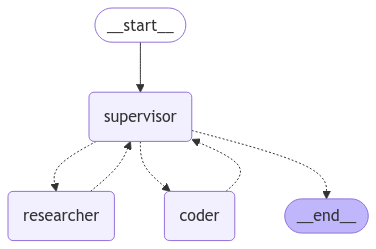

In [36]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

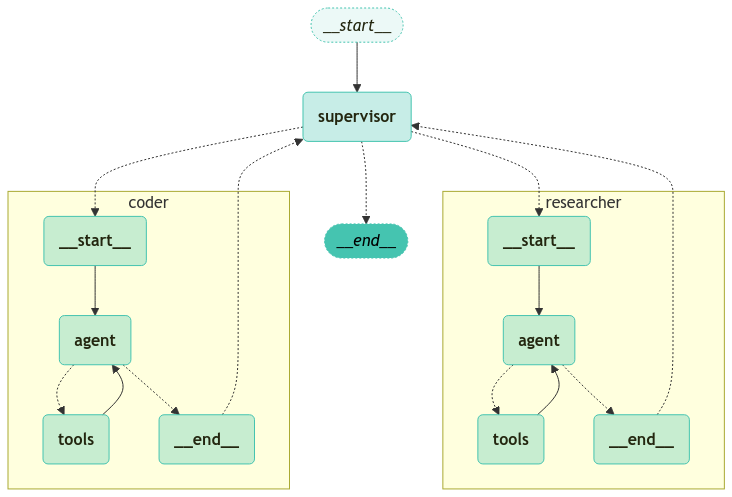

In [37]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph, xray=True)

## 팀 호출

그래프가 생성되었으므로, 이제 그래프를 호출하여 어떻게 작동하는지 확인할 수 있습니다!

In [38]:
import pprint
# agent 호출을 통해 그래프를 실행합니다.
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]},
    {"recursion_limit": 100},
    subgraphs=True
):
    pprint.pprint(s)
    print("----")

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "What's the square root of 42?"
    ]
  ]
}
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "What's the square root of 42?"
    ]
  ]
}
[chain/start] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<...>] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "What's the square root of 42?"
    ]
  ]
}
[chain/end] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<...>] s] Exiting Chain run with output:
{
  "messages": [
    [
      "user",
      "What's the square root of 42?"
    ]
  ]
}
[chain/start] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<start:supervisor>] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "What's the square root of 42?"
    ]
  ]
}
[chain/end] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<start:supervi

KeyboardInterrupt: 

In [ ]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})


inputs ={
        "messages": [
            (
                "user",
                "What's the square root of 42?"
            )
        ],
    }
    

invoke_graph(graph, inputs, config)


🔄 Node: supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
researcher

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

I am designed to be a researcher and do not have the capability to perform calculations.

🔄 Node: researcher 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: researcher

I am designed to be a researcher and do not have the capability to perform calculations.

🔄 Node: supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
coder

🔄 Node: agent in [coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  python_repl_tool (7210a78f-1572-4c95-9b6f-5a7e7787db7f)
 Call ID: 7210a78f-1572-4c95-9b6f-5a7e7787db7f
  Args:
    code: import math
pr